In [ ]:
import numpy as np
import scipy as sp
from scipy.special import multigammaln
from scipy.stats import invwishart, invgamma
import matplotlib.pyplot as plt
# Generate the same set of random samples across different runs of the notebook
np.random.seed(1331)

In [ ]:
mean = np.zeros(2)
covariance = np.asarray([[1,0],[0,2]])
N = [10,100,1000]

# **Question 1**
We estimate the covariance matrix using a Maximum Likelihood approach.



In [ ]:
def get_outer(y):
    # get outer products for a list of  vectors y of shape (n, d)
    return np.expand_dims(y, axis=1)*np.expand_dims(y, axis=2)

errors = dict()
for n in N:
    np.random.seed(1331)
    y = np.random.multivariate_normal(mean, covariance, n)
    S = (y-mean).T@(y-mean)/n
    error = np.mean((S-covariance)**2)
    errors[n] = error
    '''
    Equivalent to-
    S = np.zeros_like(covariance)
    for i in range(n):
    S = S+np.outer(y[i], y[i])
    S = S/n
    '''
    print(f'For n={n}, the ML estimate of the covariance is :\n {S}\n')
print(f"The MSE for different values of n: ", errors)

For n=10, the ML estimate of the covariance is :
 [[ 0.23404612 -0.23014765]
 [-0.23014765  1.5964973 ]]

For n=100, the ML estimate of the covariance is :
 [[0.78739204 0.00468903]
 [0.00468903 1.76640547]]

For n=1000, the ML estimate of the covariance is :
 [[ 0.96045475 -0.0267397 ]
 [-0.0267397   1.86165738]]

The MSE for different values of n:  {10: 0.21385891597060924, 100: 0.02495313032570341, 1000: 0.005533132614184367}


# **Question 2**
We perform Bayesian estimation using the given inverse Wishart prior. We choose the mode of the posterior distribution (MAP) as our point estimate for the covariance matrix.

In [ ]:
delta_0 = np.asarray([[4,0],[0,5]])
v_0 = 5
d = 2

In [ ]:
errors = dict()
for n in N:
    vn = v_0 + n
    np.random.seed(1331)
    y = np.random.multivariate_normal(mean, covariance, n)
    S = y.T@y
    delta_n = delta_0 + S
    error = np.mean(delta_n/(vn+d+1)-covariance)**2
    print('abs error :', (delta_n/(vn+d+1)-covariance)**2)
    errors[n] = error
    """
    mode of inverse wishart is delta/(v+d+1)
    """
    print(f'For n={n}, the MAP estimate is :\n{delta_n/(vn+d+1)}\n')
print(f"The MSE for different values of n: ", errors)

abs error : [[0.41958286 0.01634813]
 [0.01634813 0.69769147]]
For n=10, the MAP estimate is :
[[ 0.35224784 -0.12785981]
 [-0.12785981  1.16472072]]

abs error : [[5.47074585e-02 1.88503438e-05]
 [1.88503438e-05 1.01215021e-01]]
For n=100, the MAP estimate is :
[[0.76610374 0.0043417 ]
 [0.0043417  1.68185692]]

abs error : [[0.00186621 0.00070371]
 [0.00070371 0.0219506 ]]
For n=1000, the MAP estimate is :
[[ 0.95680035 -0.02652748]
 [-0.02652748  1.85184264]]

The MSE for different values of n:  {10: 0.18895345048604156, 100: 0.018452229984529247, 1000: 0.003733575799003263}


# **Question 3**

In [ ]:
K = [1.5, 2]
errors = np.zeros((len(N), len(K)))
for n in N:
    for k in K:
        np.random.seed(1331)
        y = np.random.multivariate_normal(mean, covariance, n)
        S = y.T@y
        S = S/(n+2*k)
        error = np.mean((S-covariance)**2)
        errors[N.index(n), K.index(k)] = error

        print(f'For n={n} and k={k}, the covariance estimate is\n {S}\n')
print(f"The MSE for different configurations are:\n{errors}")

For n=10 and k=1.5, the covariance estimate is
 [[ 0.18003547 -0.17703666]
 [-0.17703666  1.22807485]]

For n=10 and k=2, the covariance estimate is
 [[ 0.1671758  -0.16439118]
 [-0.16439118  1.14035522]]

For n=100 and k=1.5, the covariance estimate is
 [[0.76445829 0.00455246]
 [0.00455246 1.71495677]]

For n=100 and k=2, the covariance estimate is
 [[0.75710773 0.00450869]
 [0.00450869 1.6984668 ]]

For n=1000 and k=1.5, the covariance estimate is
 [[ 0.95758201 -0.02665972]
 [-0.02665972  1.85608911]]

For n=1000 and k=2, the covariance estimate is
 [[ 0.95662824 -0.02663317]
 [-0.02663317  1.85424042]]

The MSE for different configurations are:
[[0.33272355 0.37165856]
 [0.03419275 0.0374899 ]
 [0.00598278 0.0061364 ]]


# **Question 4**
Here, we obtain the mean of the posterior distribution with Monte-Carlo integration

In [ ]:
d = 2
M = [1e3, 1e4, 1e5] # configurations for m
M = list(map(int, M)) # convert to int
# prior parameters
delta_0 = np.asarray([[4,0],[0,5]])
v_0 = 5

In [ ]:
def get_pow(y, sigma):  # returns the exp term in joint prob of yi's
    # y should be of shape (n, d)
    return -0.5 * (y@np.linalg.inv(sigma)*y).sum()

errors = np.zeros((len(N), len(M)))
for n in N:
    for m in M:
        np.random.seed(1331)
        y = np.random.multivariate_normal(mean, covariance, n)  # draw samples
        sigma_draws = invwishart.rvs(
            df=v_0, scale=delta_0, size=m, random_state=1331)
        # get list of determinants
        dets = list(map(np.linalg.det, sigma_draws))
        dets = np.array(dets)
        dets = np.abs(dets)
        # get list of powers in exp term
        exps = [get_pow(y, sigma) for sigma in sigma_draws]
        exps = np.array(exps)
        assert len(exps) == m
        exp_pow_and_det = exps - n * np.log(dets)/2
        # subtract the maximum to avoid underflow issues
        exp_pow_and_det = exp_pow_and_det - np.max(exp_pow_and_det)
        exps = np.exp(exp_pow_and_det)  # denominator terms

        mc_probs = np.multiply(
            sigma_draws, exps[:, None, None])  # numerator terms
        mc_probs = np.mean(mc_probs, axis=0)
        mc_det_exp = np.mean(exps, axis=0)
        mc_est = mc_probs/mc_det_exp
        error = np.mean((mc_est-covariance)**2)
        errors[N.index(n), M.index(m)] = error
        print(f'The Monte Carlo estimate for n={n} and m={m} is :\n{mc_est}\n')
print(f"The MSE for different configurations are:\n{errors}")

The Monte Carlo estimate for n=10 and m=1000 is :
[[ 0.51396914 -0.15473103]
 [-0.15473103  1.69107867]]

The Monte Carlo estimate for n=10 and m=10000 is :
[[ 0.52164579 -0.18104767]
 [-0.18104767  1.72601857]]

The Monte Carlo estimate for n=10 and m=100000 is :
[[ 0.52765013 -0.1918839 ]
 [-0.1918839   1.75308326]]

The Monte Carlo estimate for n=100 and m=1000 is :
[[ 0.82797847 -0.01540917]
 [-0.01540917  1.79003539]]

The Monte Carlo estimate for n=100 and m=10000 is :
[[0.80470482 0.01213497]
 [0.01213497 1.7633306 ]]

The Monte Carlo estimate for n=100 and m=100000 is :
[[0.81197206 0.00433997]
 [0.00433997 1.78257587]]

The Monte Carlo estimate for n=1000 and m=1000 is :
[[ 0.92138389 -0.00835238]
 [-0.00835238  1.96858072]]

The Monte Carlo estimate for n=1000 and m=10000 is :
[[ 0.95396398 -0.0135664 ]
 [-0.0135664   1.84490454]]

The Monte Carlo estimate for n=1000 and m=100000 is :
[[ 0.95757582 -0.02296548]
 [-0.02296548  1.86585303]]

The MSE for different configurations

In [ ]:
# different prior parameters
d = 2
M = [1e3, 1e4, 1e5] # configurations for m
M = list(map(int, M)) # convert to int
# prior parameters
delta_0 = np.asarray([[2,0],[0,4]])
v_0 = 5

In [ ]:
errors = np.zeros((len(N), len(M)))
for n in N:
    for m in M:
        np.random.seed(1331)
        y = np.random.multivariate_normal(mean, covariance, n)  # draw samples
        sigma_draws = invwishart.rvs(
            df=v_0, scale=delta_0, size=m, random_state=1331)
        # get list of determinants
        dets = list(map(np.linalg.det, sigma_draws))
        dets = np.array(dets)
        dets = np.abs(dets)
        # get list of powers in exp term
        exps = [get_pow(y, sigma) for sigma in sigma_draws]
        exps = np.array(exps)
        assert len(exps) == m
        exp_pow_and_det = exps - n * np.log(dets)/2
        # subtract the maximum to avoid underflow issues
        exp_pow_and_det = exp_pow_and_det - np.max(exp_pow_and_det)
        exps = np.exp(exp_pow_and_det)  # denominator terms
        mc_probs = np.multiply(
            sigma_draws, exps[:, None, None])  # numerator terms
        mc_probs = np.mean(mc_probs, axis=0)
        mc_det_exp = np.mean(exps, axis=0)
        mc_est = mc_probs/mc_det_exp
        error = np.mean((mc_est-covariance)**2)
        errors[N.index(n), M.index(m)] = error
        print(f'The Monte Carlo estimate for n={n} and m={m} is :\n{mc_est}\n')
print(f"The MSE for different configurations are:\n{errors}")

The Monte Carlo estimate for n=10 and m=1000 is :
[[ 0.36413297 -0.15657764]
 [-0.15657764  1.58559334]]

The Monte Carlo estimate for n=10 and m=10000 is :
[[ 0.36075189 -0.18418298]
 [-0.18418298  1.64330882]]

The Monte Carlo estimate for n=10 and m=100000 is :
[[ 0.36159466 -0.19190591]
 [-0.19190591  1.6706303 ]]

The Monte Carlo estimate for n=100 and m=1000 is :
[[ 0.84167801 -0.01667896]
 [-0.01667896  1.81482923]]

The Monte Carlo estimate for n=100 and m=10000 is :
[[0.78269321 0.02247481]
 [0.02247481 1.78066563]]

The Monte Carlo estimate for n=100 and m=100000 is :
[[0.79354022 0.00619282]
 [0.00619282 1.76846065]]

The Monte Carlo estimate for n=1000 and m=1000 is :
[[0.9448025  0.00497156]
 [0.00497156 2.04607127]]

The Monte Carlo estimate for n=1000 and m=10000 is :
[[0.94808812 0.00559614]
 [0.00559614 1.82540211]]

The Monte Carlo estimate for n=1000 and m=100000 is :
[[ 0.96476384 -0.02512341]
 [-0.02512341  1.85828241]]

The MSE for different configurations are:
[[

# **Question 5**
Heirarchical model with Gibbs sampling

In [ ]:
A1 = 0.05
A2 = 0.05
A =  [A1, A2]
d = 2
nu = 5
n_iters = 1000

In [ ]:
errors = dict()
for n in N:
    np.random.seed(1331)
    y = np.random.multivariate_normal(mean, covariance, n)  # draw samples
    outer_prods = get_outer(y)
    a = [0, 0]
    for j in range(2):
        a[j] = invgamma.rvs(1/2, scale=1/A[j]**2, random_state=1331)
    for i in range(n_iters):
        scale = 2*nu*np.diag([1/a[0], 1/a[1]]) + np.sum(outer_prods, axis=0)
        sigma = invwishart.rvs(
            df=nu + d + n - 1, scale=scale, size=1, random_state=1331)
        sigma_inv = np.linalg.inv(sigma)
        for j in range(2):
            a[j] = invgamma.rvs((nu + n)/2, scale=nu *
                                sigma_inv[j, j] + 1/A[j]**2, random_state=1331)
    final_scale = 2*nu*np.diag([1/a[0], 1/a[1]]) + np.sum(outer_prods, axis=0)
    final_nu = nu + d + n - 1
    sigma = final_scale/(final_nu + d + 1)  # mode
    error = np.mean((sigma-covariance)**2)
    errors[n] = error
    print(f'The estimate from Gibbs sampling, for n={n} is :\n{sigma}\n')
print(f"The MSE for different values of n are:\n{errors}")

The estimate from Gibbs sampling, for n=10 is :
[[ 0.13927721 -0.12113034]
 [-0.12113034  0.85740062]]

The estimate from Gibbs sampling, for n=100 is :
[[0.7373825  0.00430187]
 [0.00430187 1.63568748]]

The estimate from Gibbs sampling, for n=1000 is :
[[ 0.96519996 -0.02650119]
 [-0.02650119  1.85844442]]

The MSE for different values of n are:
{10: 0.5189305469766614, 100: 0.05043214384452743, 1000: 0.0056634124420815455}


# **Question 6**
Empirical Bayes

In [ ]:
# Newton Raphson method
thresh = 1e-5  # stopping criteria
eps = 1e-8
n = 1000
d = 2
errors = dict()
for n in N:
    diff = np.inf
    nu = d-1 + eps  # initialisation
    k = 0
    np.random.seed(1331)
    y = np.random.multivariate_normal(mean, covariance, n)  # draw samples
    while diff > thresh:
        grad_ = np.array([1/(nu+n-i+1-2*j + 1e-8)
                          for i in range(1, d+1) for j in range(1, n//2+1)])
        grad = np.log((nu+n)/nu) - np.sum(grad_)
        grad_grad = 1/(nu + n) - 1/nu + np.sum(grad_**2)
        diff = abs(grad/(grad_grad))
        nu = nu - grad/(grad_grad)
        k += 1
    print(f'Convergence to {nu} achieved in {k} step(s)')
    nu_opt = nu
    S = y.T@y/n
    delta_opt = nu_opt*S
    nu_n = nu_opt+n
    delta_n = delta_opt + n*S
    errors[n] = np.mean((delta_n/(nu_n+d+1)-covariance)**2)
    print(f'The MAP estimate for n={n} is :\n{delta_n/(nu_n+d+1)}\n')
print(f"The MSE for different values of n are:\n{errors}")

Convergence to 1.000000030000001 achieved in 1 step(s)
The MAP estimate for n=10 is :
[[ 0.18389338 -0.1808303 ]
 [-0.1808303   1.25439074]]

Convergence to 1.0000000299999938 achieved in 1 step(s)
The MAP estimate for n=100 is :
[[0.76467881 0.00455377]
 [0.00455377 1.71545147]]

Convergence to 1.000000030000008 achieved in 1 step(s)
The MAP estimate for n=1000 is :
[[ 0.95758487 -0.0266598 ]
 [-0.0266598   1.85609466]]

The MSE for different values of n are:
{10: 0.32184059629275674, 100: 0.034096350793425365, 1000: 0.005982320213016426}


# **More about the Objective Function in Question 6**

Some visualizations of the objective function for Empirical Bayes.

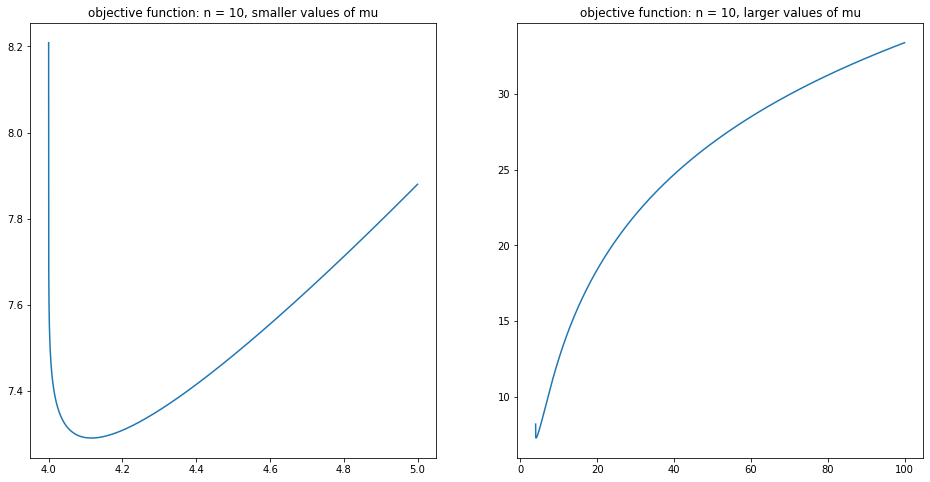

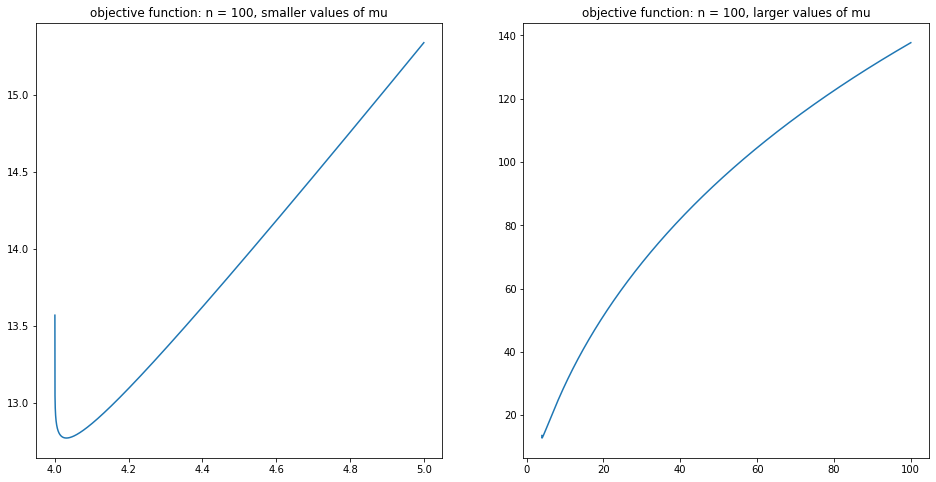

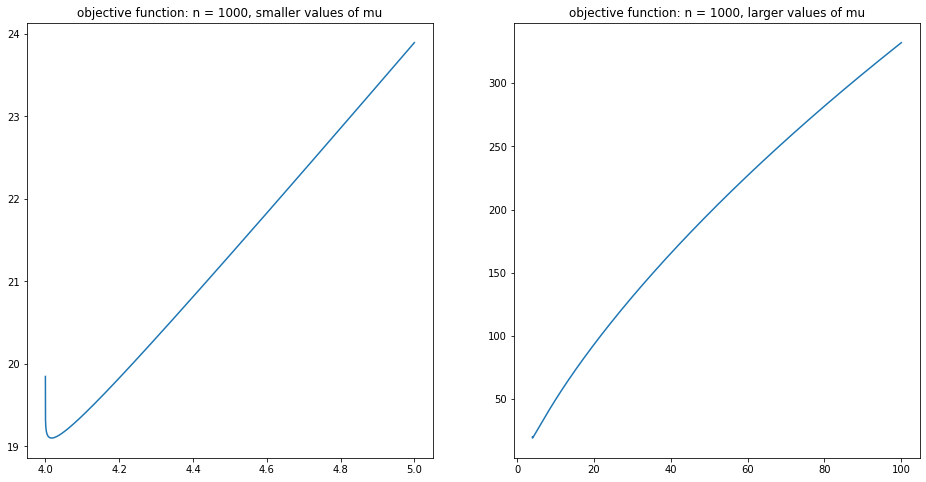

In [ ]:
def objective(v, n, d=5):
    val = v*np.log(1+n/v) + n*np.log(1+v/n) + \
        np.log(multigammaln(v/2, d)/multigammaln((v+n)/2, d))
    return val
d = 5
eps  =1e-8
for n in N:
    grid1 = np.linspace(d-1+eps, 5, 1000000)
    func_vals1 = objective(grid1, n)
    grid2 = np.linspace(d-1+eps, 100, 1000000)
    func_vals2 = objective(grid2, n)
    fig, a = plt.subplots(1, 2)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    a[0].plot(grid1, func_vals1)
    a[1].plot(grid2, func_vals2)
    a[0].set_title(f"objective function: n = {n}, smaller values of mu")
    a[1].set_title(f"objective function: n = {n}, larger values of mu")
    plt.show()
